In [2]:
!pip install qiskit
!pip install qiskit-aer
!pip install np
!pip install pylatexenc
!pip install qiskit-ibmq-provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np: filename=np-1.0.2-py3-none-any.whl size=13658 sha256=001ca46bfe97d5bcc078f0cd294c5f1ab6edbc8969dd5bb421a96c3129901ec7
  Stored in directory: /root/.cache/pip/wheels/f9/e1/79/c4580a03022dece233bc146286fc9082a8885ee1a7c8d8b980
Successfully built np
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [134]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, circuit, ClassicalRegister, QuantumRegister
import numpy as np
import matplotlib.pyplot as plt
import pylatexenc
from qiskit import *
from pylatexenc import *
from qiskit.circuit import Qubit, Clbit
from qiskit.quantum_info import state_fidelity
from qiskit import IBMQ
#from  qiskit_ibm_provider import IBMProvider
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit_aer import AerSimulator
from qiskit.quantum_info import DensityMatrix, partial_trace, hellinger_fidelity
from qiskit.visualization import array_to_latex


In [4]:
# Load your IBM Quantum Experience account
IBMQ.save_account("5f29d7e3310d88676ac35e06b8566895c8278cb29c63aa8505f3fc1493aa7db1372d7f5f1f0848918c326d282ccb344c011696bf504e5807a0cd4df6c44d607d", overwrite=True)
IBMQ.load_account()

<ipython-input-4-401e1f48aa9e>:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account("5f29d7e3310d88676ac35e06b8566895c8278cb29c63aa8505f3fc1493aa7db1372d7f5f1f0848918c326d282ccb344c011696bf504e5807a0cd4df6c44d607d", overwrite=True)


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [139]:
def run_Simulator(circuit):
  simulator_backend = Aer.get_backend('qasm_simulator')
  compiled_circuit = transpile(circuit, simulator_backend)
  job = simulator_backend.run(compiled_circuit)
  result = job.result()
  counts = result.get_counts()
  print("Measurement Results:", counts)
  return counts

def apply_Syndrome_Correction(counts, qc):
  # Getting the outcome results of applying correction
  # Only care about the 1st qubit because it is where the syndrome results are stored
  # At this point, the state is in superposition of logical 1 and logical 0
  #classical bits are little endien: 0 is the right-most bit
  # If we have an outcome of 0 (corresponding to |x> state, then do nothing to correct syndrome)
  outcomes = list(counts.keys())
  # Should we always only have one outcome?
  result = outcomes[0]
  if int(outcomes[0][-1]) == 0:
    print("No errors syndrome for this execution")
    return
  else:
    #Flag was raised. Apply corresponding syndrome correction given the data errors that could have happened.
    #For now, we are just resetting the syndrome qubit (back to 0)
    print("An error occured. Resetting qubit.")
    qc.reset(qc.qregs[0][3])

def apply_Error_Correction(counts, qc):
  #Measuring 1st/2nd qubit
  #Again, should we always have only 1 outcome state?
  outcomes = list(counts.keys())[0]
  cbits = outcomes[1:3]
  print("The Error Syndrome for this circuit run is:\n", cbits)
  if cbits == "01": #x1 Error
    qc.x(0)
  elif cbits == "10": #x3 Error
    qc.x(2)
  elif cbits == "11": #x2 Error
    qc.x(1)

# Applying the random gate errors
#0,1,2,3,
def apply_random_gate_errors_circuit(circuit):
  prob = np.random.randint(0,3)
  if prob == 0: #x1
    circuit.x(0)
  elif prob == 1: #x3
    circuit.x(2)
  elif prob == 2: #x2
    circuit.x(1)

def get_State_Fidelity(sv1, sv2):
  fidel = state_fidelity(sv1, sv2)
  print("The state fidelity is", fidel)
  return fidel


def get_Density_Matrix(c1):
  rho = DensityMatrix(c1)
  rho_a = partial_trace(state=rho, qargs=[0])
  return rho_a


def get_State_Vector(c1):
  backend = Aer.get_backend('statevector_simulator')
  results = execute(c1, backend, shots= 1024).result()
  sv1= results.get_statevector(c1)
  counts = results.get_counts(0)
  return sv1, counts

def get_Least_Busy(provider):
  small_devices = provider.backends(filters=lambda x: not x.configuration().simulator)
  backend = least_busy(small_devices)
  return backend

def run_on_Backend(qc):
  provider = IBMQ.get_provider(hub = 'ibm-q')
  backend = get_Least_Busy((provider))
  compiled_circuit = transpile(qc, backend)
  job = backend.run(compiled_circuit)
  job_monitor(job)
  result = job.result()
  counts = result.get_counts()
  print("Measurement Results:", counts)
  return counts


def arbitrary_Rotation(random = True):
    if random:
      theta = np.random.rand() * 2 * np.pi
      phi = np.random.rand() * 2 * np.pi
    else:
      #H-gate example
      theta = np.pi /2
      lambaa = np.pi
    return theta, phi

# Applying the syndrome errors
#In this case testing, IZ
def apply_syndrome_error(circuit):
    circuit.barrier()
    circuit.z(3)
    circuit.barrier()

# The Initial State for this Random Unitary on 1st Qubit

---


In [143]:
qc = QuantumCircuit(6, 4)
theta, phi = arbitrary_Rotation()
qc.u(theta, phi, 0 , 0)
#partial trace of 1st qubit
density_matrix_1 = DensityMatrix(qc)
first_qubit = partial_trace(density_matrix_1, [1,2,3,4,5])

initial_state_vec = first_qubit.to_statevector()
qc.measure(0,3)
array_to_latex(first_qubit)

<IPython.core.display.Latex object>

In [144]:
initial_state_vec.draw('latex')


<IPython.core.display.Latex object>

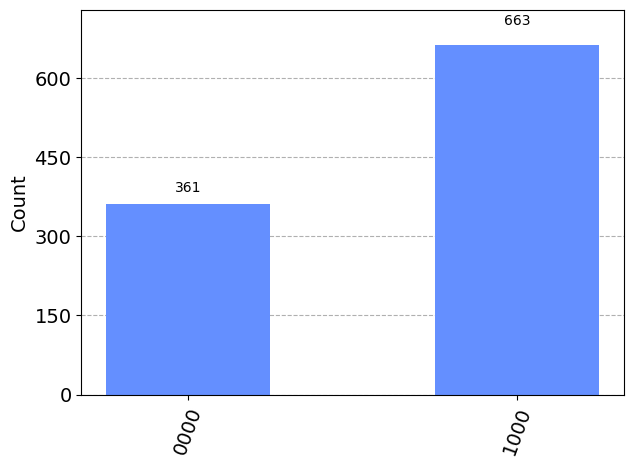

In [145]:
initial_state, counts = get_State_Vector(qc)

plot_histogram(counts)

# The Error Correction Circuit with flag Fault on ZZI Syndrome

---



In [146]:
qc = QuantumCircuit(6, 4)
qc.u(theta, phi, 0 , 0)
qc.cx(0, 1)
qc.cx(0, 2)
#flag qubit to |+> state
qc.h(5)
qc.barrier()
#Lets introduce X1 error:
#TODO: add random errors
apply_random_gate_errors_circuit(qc)
qc.barrier()
# Flag qubit for syndrome ZZI CNOT Error
qc.cx(5,3)
# Ancilla qubit for syndrome ZZI Extraction + syndome error
apply_syndrome_error(qc)
qc.cx(0, 3)
qc.cx(1, 3)
# Flag qubit for syndrome ZZI CNOT Error
qc.cx(5,3)
qc.barrier()
# Measurement the ZZI Flag in X basis
qc.h(5)
qc.measure(5,0)
# Mid-Circuit Measurement: Get the flag syndrome outcome
# Right now, we have an outcome of 0 for the ZZI syndrome on logical O anf 1 on logical 1 for X1 error (with no CNOT errors)
counts = run_Simulator(qc)
apply_Syndrome_Correction(counts, qc)
qc.barrier()
# Ancilla qubit for syndrome IZZ Extraction
qc.cx(1, 4)
qc.cx(2, 4)
# Ancilla Quibt for syndrome IZZ Extraction
qc.barrier()
# Error Syndrome Measurement for both
qc.measure([3,4],[1,2])
# Mid-Circuit Measurement: Get the Error Outcomes
counts = run_Simulator(qc)
apply_Error_Correction(counts, qc)
#Decoder Circuit
qc.barrier()
qc.cx(0, 2)
qc.cx(0, 1)
qc.barrier()
final_state, counts_final = get_State_Vector(qc)


Measurement Results: {'0001': 1024}
An error occured. Resetting qubit.
Measurement Results: {'0101': 1024}
The Error Syndrome for this circuit run is:
 10


In [147]:
#the partial trace of 1st qubit
rho_a = partial_trace(state=final_state, qargs=[1,2,3,4,5])
final_state_vec= rho_a.to_statevector()
array_to_latex(final_state_vec)

<IPython.core.display.Latex object>

In [148]:
#The Density Matrix
array_to_latex(rho_a)

<IPython.core.display.Latex object>

Measurement Results: {'1101': 668, '0101': 356}
The state fidelity is 1.0


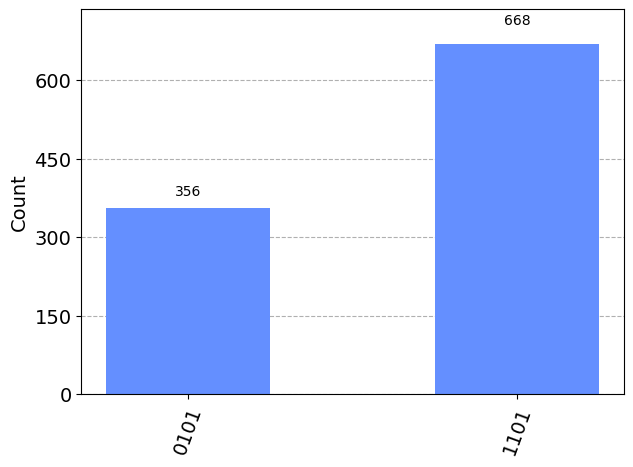

In [149]:
qc.measure([0],[3])
# Final Measurement: Get the Decoded State
# Will collapse to 1 or 0 since we created an arbitrary state, with a probability that reflects the amplitdues from the arbitrary rotation
counts = run_Simulator(qc)

#Get the State Fidelity
fidel = get_State_Fidelity(initial_state_vec, final_state_vec)
plot_histogram(counts)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


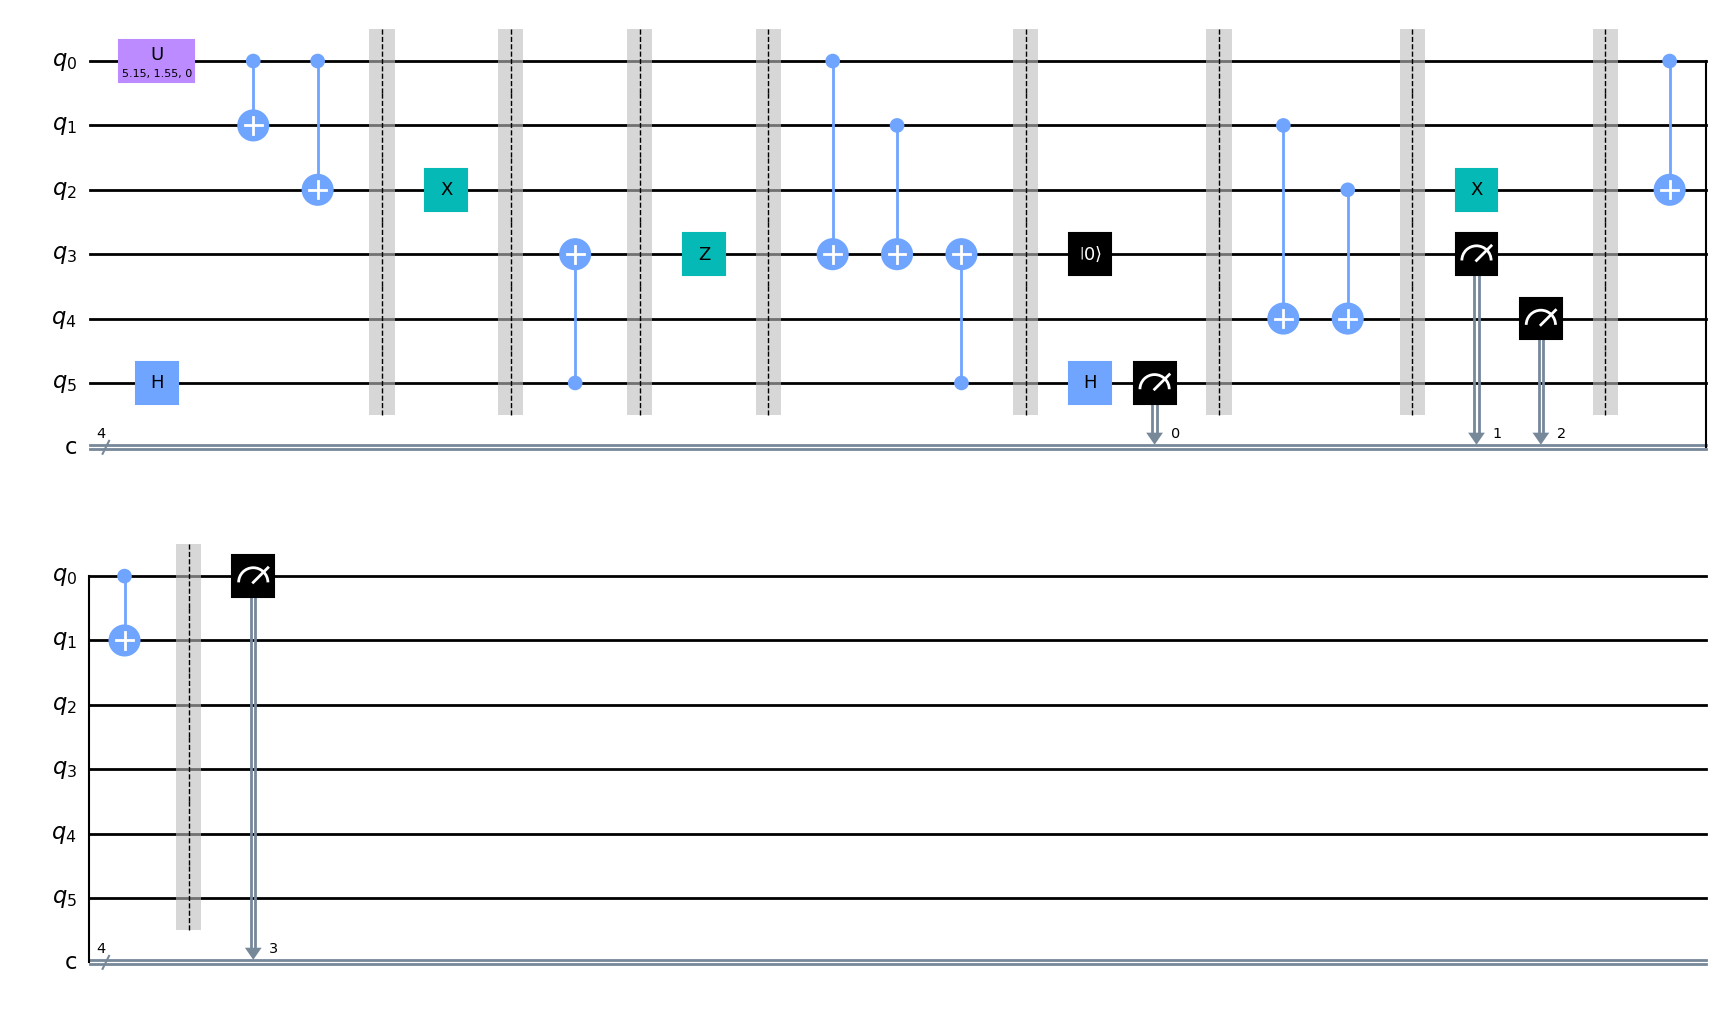

In [118]:
qc.draw(output='mpl')

# **Same Ciruit on running on Real Backend**

In [153]:
qc1 = QuantumCircuit(6, 4)
# Using Previous rotation values
#theta, lambdaa = arbitrary_Rotation()
qc1.u(theta, phi,0 , 0)
qc1.measure(0,3)
counts_real_1 = run_on_Backend(qc1)

Job Status: job has successfully run
Measurement Results: {'0000': 1458, '1000': 2542}


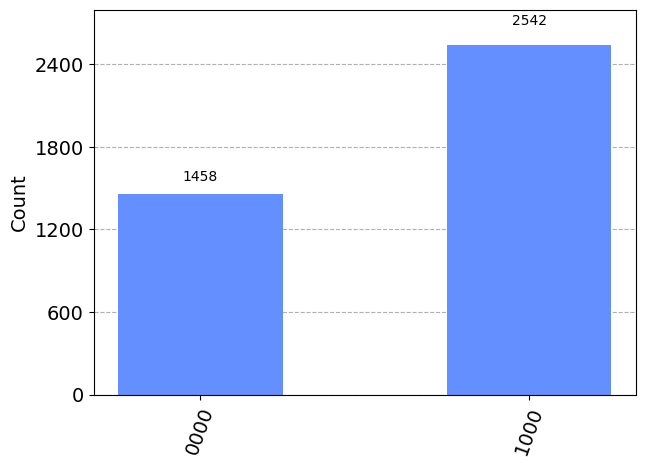

In [154]:
plot_histogram(counts_real_1)

In [162]:
qc1 = QuantumCircuit(6, 4)
# Using Previous rotation values
#theta, lambdaa = arbitrary_Rotation()
qc1.u(theta, phi,0 , 0)
qc1.cx(0, 1)
qc1.cx(0, 2)
#flag qubit to |+> state
qc1.h(5)
qc1.barrier()
# Add random errors
apply_random_gate_errors_circuit(qc1)
qc1.barrier()
# Flag qubit for syndrome ZZI CNOT Error
qc1.cx(5,3)
# Ancilla qubit for syndrome ZZI Extraction
apply_syndrome_error(qc1)
qc1.cx(0, 3)
qc1.cx(1, 3)
# Flag qubit for syndrome ZZI CNOT Error
qc1.cx(5,3)
qc1.barrier()
# Measurement the ZZI Flag in X basis
qc1.h(5)
qc1.measure(5,0)
# Mid-Circuit Measurement: Get the flag syndrome outcome
# Right now, we have an outcome of 0 for the ZZI syndrome on logical O anf 1 on logical 1 for X1 error (with no CNOT errors)
counts_real_syn = run_on_Backend(qc1)

Job Status: job has successfully run
Measurement Results: {'0000': 1900, '0001': 2100}


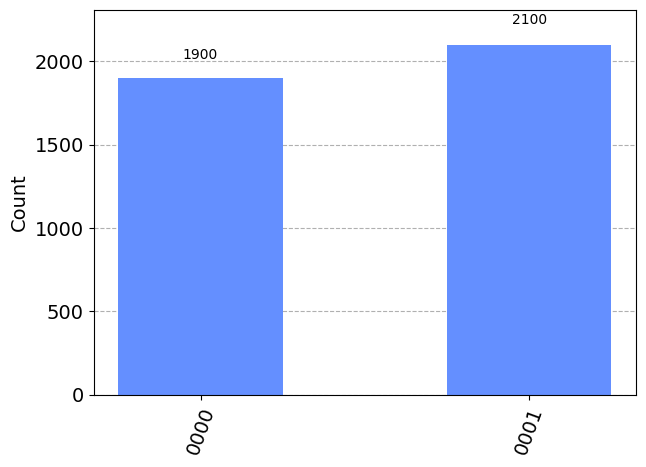

In [163]:
plot_histogram(counts_real_syn)

In [164]:
apply_Syndrome_Correction(counts_real_syn, qc1)
qc1.barrier()
# Ancilla qubit for syndrome IZZ Extraction
qc1.cx(1, 4)
qc1.cx(2, 4)
# Ancilla Quibt for syndrome IZZ Extraction
qc1.barrier()
# Error Syndrome Measurement for both
qc1.measure([3,4],[1,2])
# Mid-Circuit Measurement: Get the Error Outcomes
counts_real_error = run_on_Backend(qc1)

No errors syndrome for this execution
Job Status: job has successfully run
Measurement Results: {'0111': 168, '0011': 1529, '0110': 184, '0101': 86, '0010': 1649, '0001': 156, '0100': 106, '0000': 122}


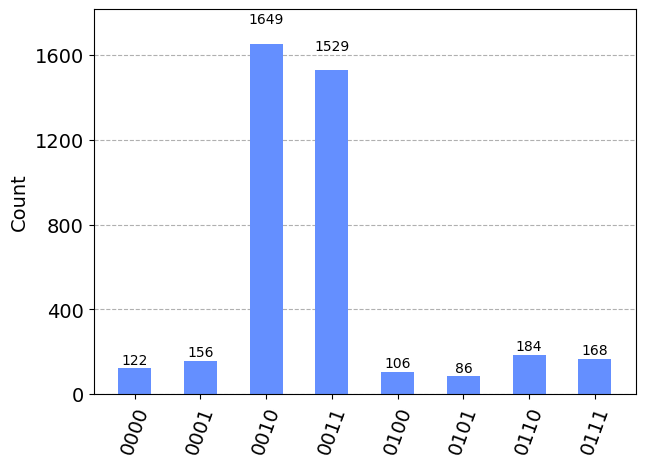

In [165]:
plot_histogram(counts_real_error)

In [166]:
apply_Error_Correction(counts_real_error, qc1)
#Decoder Circuit
qc1.barrier()
qc1.cx(0, 2)
qc1.cx(0, 1)
qc1.barrier()
qc1.measure([0],[3])
final_state = get_State_Vector(qc1)
#print("final state vector", final_state)
# Final Measurement: Get the Decoded State
# Will collapse to 1 or 0 since we created an arbitrary state, with a probability that reflects the amplitdues from the arbitrary rotation
counts_real_final = run_on_Backend(qc1)

The Error Syndrome for this circuit run is:
 11
Job Status: job has successfully run
Measurement Results: {'0111': 90, '0101': 33, '1010': 129, '0011': 624, '0000': 83, '0001': 57, '1111': 91, '1101': 50, '0010': 1481, '1110': 17, '0100': 69, '1001': 78, '1100': 28, '0110': 167, '1000': 26, '1011': 977}


# **In this run, another error occured due to the system noise, leading to incorrect syndrome**

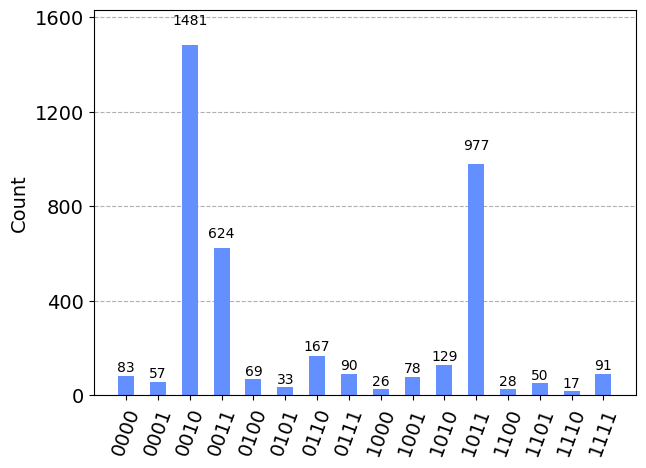

In [168]:
plot_histogram(counts_real_final)

In [169]:
#Get the State Fidelity between the probaility distirbutions
hellinger_fidelity(counts_real_1, counts_real_final)

0.02287310729379583

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


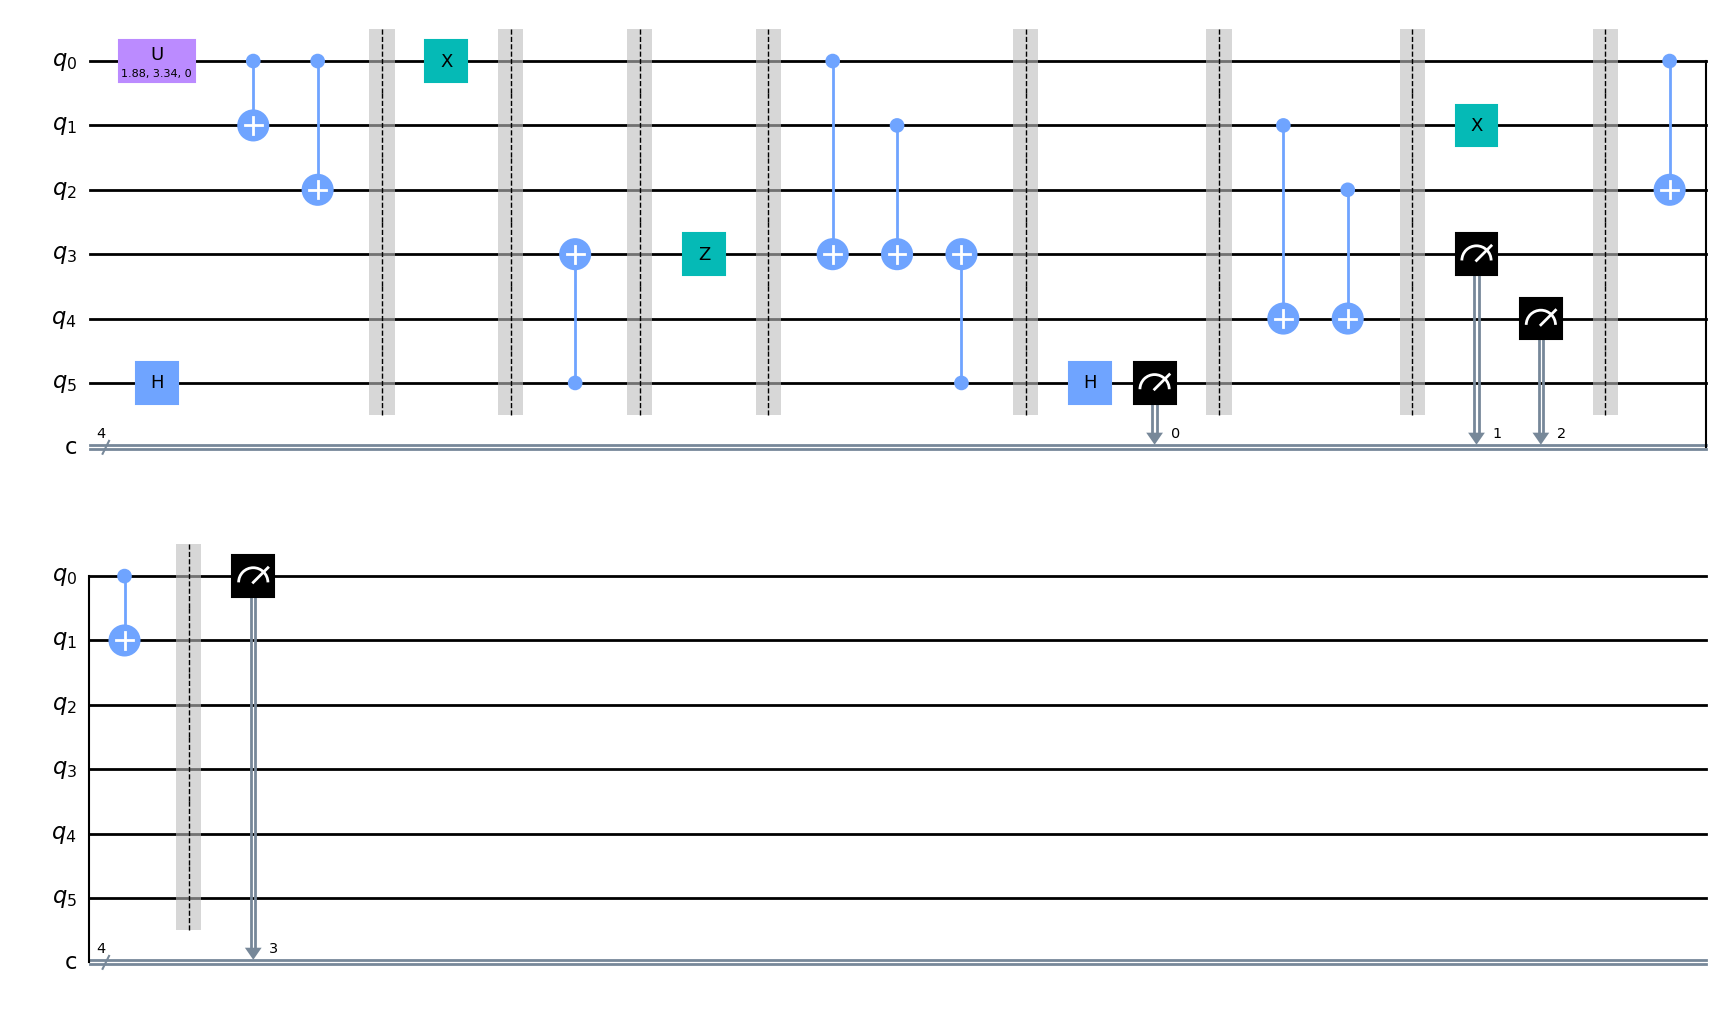

In [170]:
qc1.draw(output ='mpl')